In [1]:
pip install pyscenic

In [ ]:
import os
import glob
import pickle
import pandas 
import numpy 

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase 
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn

In [31]:
from urllib.request import urlretrieve
url = 'https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc_v10_clust/gene_based/hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather'
urlretrieve(url,'hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather' )

('hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather',
 <http.client.HTTPMessage at 0x7f910776ff10>)

In [ ]:
url = 'https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl'
urlretrieve(url,'motifs-v9-nr.hgnc-m0.001-o0.0.tbl' )

In [ ]:
url_='https://raw.githubusercontent.com/aertslab/pySCENIC/master/resources/hs_hgnc_tfs.txt'
urlretrieve(url_l,'hs_hgnc_tfs.txt')

In [32]:
DATABASES_GLOB = os.path.join("hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather")
MOTIFS_HGNC_FNAME = os.path.join('motifs-v9-nr.hgnc-m0.001-o0.0.tbl')
CURATED_TFS_HGNC_FNAME = os.path.join('lambert2018.txt')

OUT_TFS_HGNC_FNAME = os.path.join('hs_hgnc_tfs.txt')
OUT_TFS_HGNC_FNAME = os.path.join('hs_hgnc_curated_tfs.txt')

In [62]:
ADJACENCIES_FNAME = os.path.join("adjacencies.tsv")

In [78]:
MODULES_FNAME = os.path.join("modules.p")

In [81]:
MOTIFS_FNAME = os.path.join("motifs.csv")

In [79]:
REGULONS_FNAME = os.path.join("regulons.p")

In [3]:
df_motifs_hgnc = pandas.read_csv(MOTIFS_HGNC_FNAME, sep='\t')
hs_tfs = df_motifs_hgnc.gene_name.unique()
with open(OUT_TFS_HGNC_FNAME, 'wt') as f:
    f.write('\n'.join(hs_tfs) + '\n')
len(hs_tfs)

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_7742/406204144.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_motifs_hgnc = pandas.read_csv(MOTIFS_HGNC_FNAME, sep='\t')


1839

In [4]:
with open(CURATED_TFS_HGNC_FNAME, 'rt') as f:
    hs_curated_tfs = list(map(lambda s: s.strip(), f.readlines()))
len(hs_curated_tfs)

1639

In [5]:
hs_curated_tfs_with_motif = list(set(hs_tfs).intersection(hs_curated_tfs))
len(hs_curated_tfs_with_motif)

1390

In [6]:
with open(OUT_TFS_HGNC_FNAME, 'wt') as f:
    f.write('\n'.join(hs_curated_tfs_with_motif) + '\n')

In [11]:
#Glioblastoma source: https://singlecell.broadinstitute.org/single_cell/study/SCP10/glioblastoma-intra-tumor-heterogeneity
filename = 'Glioblastoma_expressed_genes.txt'
data1= pandas.read_table(filename, delimiter='\t', header=0,index_col=0)
data=data1.transpose()
data.head()

GENE,A2M,AAAS,AAK1,AAMP,AARS,AARSD1,AASDH,AASDHPPT,AASS,AATF,...,ZSCAN30,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZXDC,ZYG11B,ZYX,ZZZ3
MGH264_A01,0.0,0.000000,0.000000,8.471800,8.212539,1.148348,7.280847,8.315297,6.301266,6.185458,...,8.855828,4.730564,0.000000,0.0,0.000000,0.0,1.148348,6.428980,0.000000,0.0
MGH264_A02,0.0,0.000000,0.826908,8.179233,0.000000,3.643079,6.080252,1.721877,8.743318,9.428493,...,5.505911,0.000000,0.000000,0.0,0.000000,0.0,0.000000,5.961101,4.673498,0.0
MGH264_A03,0.0,0.000000,5.718741,0.000000,0.000000,3.122213,0.000000,0.000000,6.557108,0.000000,...,0.000000,0.000000,8.640176,0.0,0.000000,0.0,3.243285,3.256131,3.243285,0.0
MGH264_A04,0.0,0.000000,2.319947,9.334512,0.000000,0.000000,6.982978,0.000000,9.479903,0.000000,...,7.046613,6.773274,2.263933,0.0,0.000000,0.0,0.000000,1.536796,0.000000,0.0
MGH264_A05,0.0,7.632395,1.818624,0.000000,8.136521,7.721043,8.008524,8.373760,9.054301,0.000000,...,0.000000,0.000000,7.447092,0.0,8.572684,0.0,7.659566,3.293084,0.000000,0.0


In [42]:
gene_names= list(data.columns)

'AAAS'

In [54]:
tf_names = load_tf_names(MOTIFS_HGNC_FNAME)

In [45]:
type(tf_names)

list

In [37]:
#db_fnames = glob.glob(DATABASES_GLOB)
#def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
#dbs = [FeatherRankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
#dbs

[FeatherRankingDatabase(name="hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings")]

In [38]:
#dbs

[FeatherRankingDatabase(name="hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings")]

Phase I: Inference of co-expression modules

In [57]:
adjancencies = grnboost2(expression_data=data,gene_names=gene_names ,tf_names=hs_curated_tfs, verbose=True)

preparing dask client


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


parsing input
creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster
finished


In [66]:
adjancencies.head()

,TF,target,importance
351,ZNF471,MORC4,67.505206
235,ZKSCAN3,MIPOL1,66.916762
235,ZKSCAN3,TMEM45A,65.381838
351,ZNF471,TMEM212,64.594260
351,ZNF471,MIPOL1,64.449190


In [68]:
adjancencies.to_csv(ADJACENCIES_FNAME, index=False, sep='\t')
#adjacencies = pd.read_csv(ADJACENCIES_FNAME, sep='\t')

### Derive potential regulomes from these co-expression modules

In [69]:
modules = list(modules_from_adjacencies(adjancencies, data))


2022-09-06 16:00:18,709 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-09-06 16:00:19,043 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-09-06 16:00:33,974 - pyscenic.utils - INFO - Creating modules.


In [73]:
with open(MODULES_FNAME, 'wb') as f:
    pickle.dump(modules, f)

#with open(MODULES_FNAME, 'rb') as f:
#    modules = pickle.load(f)

Phase II: Prune modules for targets with cis regulatory footprints (aka RcisTarget)

In [74]:
df = prune2df(dbs, modules, MOTIFS_HGNC_FNAME)

In [77]:
df.head()

Enrichment                                  \
                                   AUC       NES MotifSimilarityQvalue   
TF     MotifID                                                           
ETV5   hdpi__ETV4             0.065753  3.808073              0.000984   
KLF12  transfac_pro__M07277   0.111382  3.160480              0.000203   
       transfac_pro__M07461   0.109791  3.089804              0.000000   
KLF9   transfac_pro__M07461   0.077096  3.185689              0.000000   
ZNF274 transfac_pro__M04916   0.061384  3.085305              0.000001   

                                                 \
                            OrthologousIdentity   
TF     MotifID                                    
ETV5   hdpi__ETV4                           1.0   
KLF12  transfac_pro__M07277                 1.0   
       transfac_pro__M07461                 1.0   
KLF9   transfac_pro__M07461                 1.0   
ZNF274 transfac_pro__M04916                 1.0   

                                                                                \
                                                                    Annotation   
TF     MotifID                                                                   
ETV5   hdpi__ETV4            gene is annotated for similar motif cisbp__M54...   
KLF12  transfac_pro__M07277  motif similar to hocomoco__KLF12_HUMAN.H11MO.0...   
       transfac_pro__M07461                         gene is directly annotated   
KLF9   transfac_pro__M07461                         gene is directly annotated   
ZNF274 transfac_pro__M04916  gene is annotated for similar motif dbcorrdb__...   

                                                                                \
                                                                       Context   
TF     MotifID                                                                   
ETV5   hdpi__ETV4            (weight>75.0%, activating, hg38_10kbp_up_10kbp...   
KLF12  transfac_pro__M07277  (weight>75.0%, activating, hg38_10kbp_up_10kbp...   
       transfac_pro__M07461  (weight>75.0%, activating, hg38_10kbp_up_10kbp...   
KLF9   transfac_pro__M07461  (weight>75.0%, activating, hg38_10kbp_up_10kbp...   
ZNF274 transfac_pro__M04916  (weight>75.0%, activating, hg38_10kbp_up_10kbp...   

                                                                                \
                                                                   TargetGenes   
TF     MotifID                                                                   
ETV5   hdpi__ETV4            [(ABI2, 5.377827761301805), (FKBP1A, 0.7148755...   
KLF12  transfac_pro__M07277  [(KLF12, 1.0), (CHL1, 0.7830765936430791), (CD...   
       transfac_pro__M07461  [(KLF12, 1.0), (CHL1, 0.7830765936430791), (CD...   
KLF9   transfac_pro__M07461  [(FNDC3B, 1.0446615309477214), (UBE2G1, 0.4089...   
ZNF274 transfac_pro__M04916  [(FOXO3, 1.3205672314612875), (ZNF235, 0.54781...   

                                       
                            RankAtMax  
TF     MotifID                         
ETV5   hdpi__ETV4                1132  
KLF12  transfac_pro__M07277       827  
       transfac_pro__M07461       672  
KLF9   transfac_pro__M07461      1024  
ZNF274 transfac_pro__M04916      1495

In [82]:
df.to_csv(MOTIFS_FNAME)

In [83]:
regulons = df2regulons(df)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [84]:
with open(REGULONS_FNAME, 'wb') as f:
    pickle.dump(regulons, f)

#with open(REGULONS_FNAME, 'rb') as f:
#    regulons = pickle.load(f)

Phase III: Cellular regulon enrichment matrix (aka AUCell)

In [85]:
auc_mtx = aucell(data, regulons, num_workers=1)

100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.98it/s]


/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


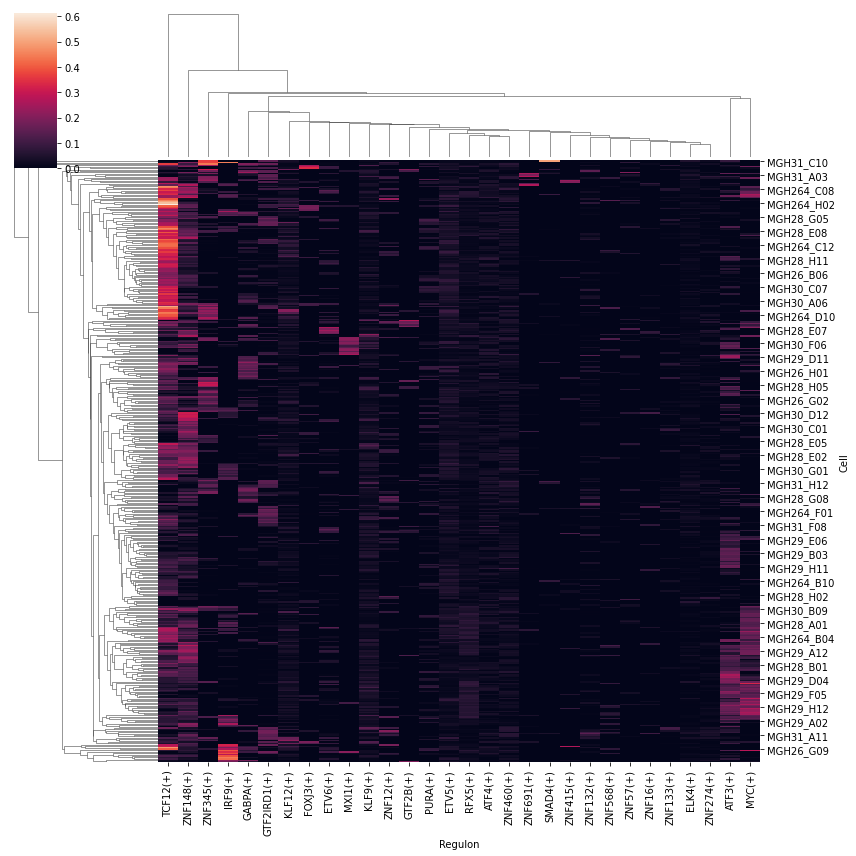

In [86]:
seaborn.clustermap(auc_mtx, figsize=(12,12))